In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
data = pd.read_csv('/content/teleconnect.csv')

In [3]:
# Drop rows with missing TotalCharges or convert to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)


In [4]:
# Drop customerID (not useful for prediction)
data.drop('customerID', axis=1, inplace=True)

**EDA**

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=data.copy()

In [7]:
# Replace empty strings with NaN and convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)


In [9]:
# Overview of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [10]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
# Convert target column 'Churn' to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

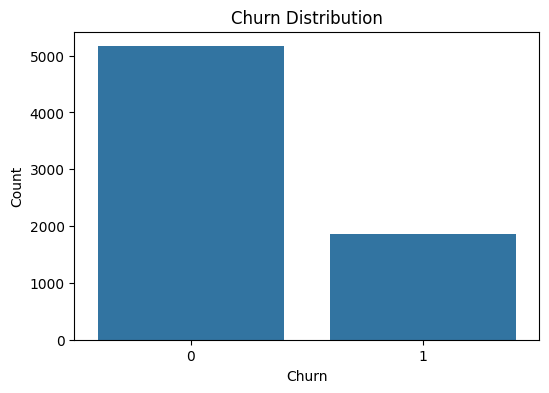

In [12]:
# Univariate analysis: Distribution of target variable
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

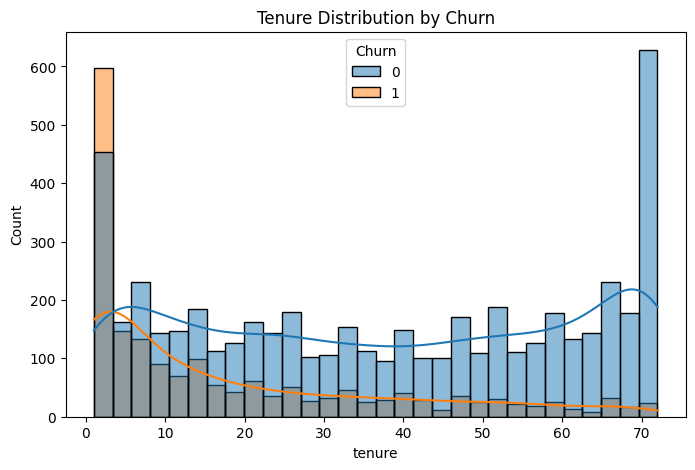

In [13]:
# Tenure distribution by churn
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Tenure Distribution by Churn')
plt.show()

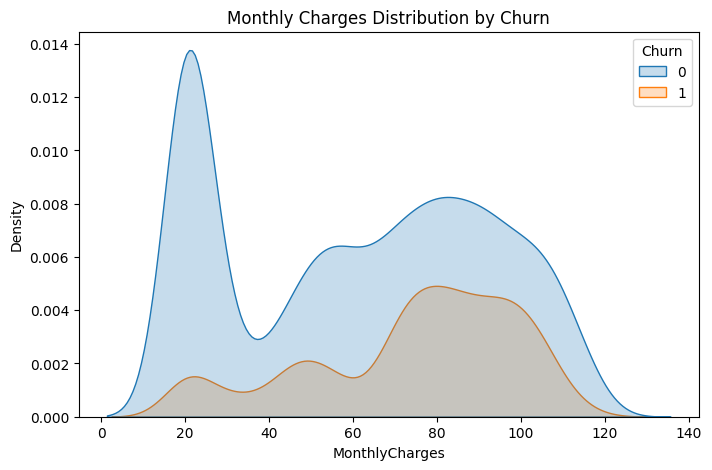

In [14]:
# Monthly Charges distribution by churn
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Monthly Charges Distribution by Churn')
plt.show()

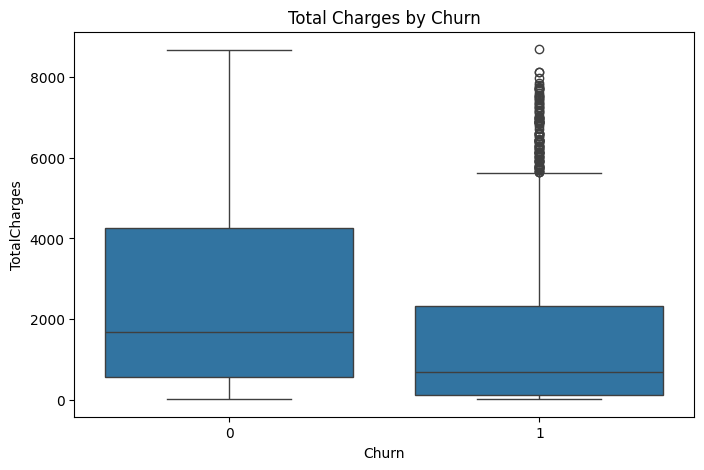

In [15]:
# Bivariate analysis: Boxplot of TotalCharges by churn
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Churn', y='TotalCharges')
plt.title('Total Charges by Churn')
plt.show()

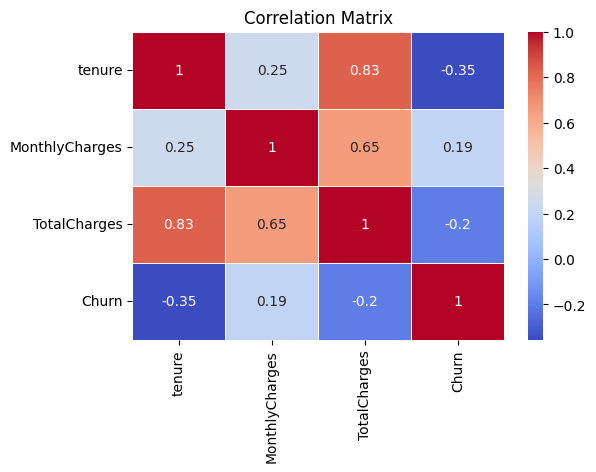

In [16]:
# Correlation matrix
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


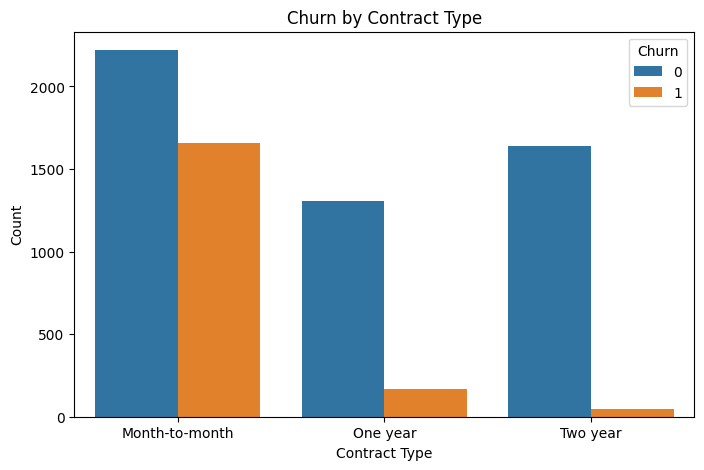

In [17]:
# Barplot: Churn rate by contract type
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

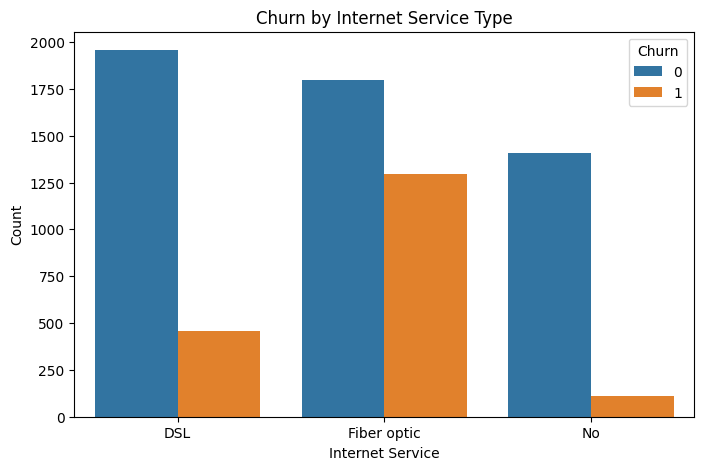

In [18]:
# Barplot: Churn rate by InternetService
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title('Churn by Internet Service Type')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.show()

In [19]:
# Encode binary categorical columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# One-hot encode other categorical variables
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod']
data = pd.get_dummies(data, columns=categorical_cols)

In [20]:
# Separate features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [21]:
# Train XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_score = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:47:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [23]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

In [24]:
# Prepare output data
output = {
    "classification_report": report,
    "confusion_matrix": conf_matrix.tolist(),
    "roc_auc_score": roc_score,
    "pca_components": X_pca[:5].tolist(),  # Sample
    "cluster_labels": clusters[:10].tolist()  # Sample
}

output


{'classification_report': {'0': {'precision': 0.846820809248555,
   'recall': 0.8476374156219865,
   'f1-score': 0.8472289156626506,
   'support': 1037.0},
  '1': {'precision': 0.8463035019455253,
   'recall': 0.8454810495626822,
   'f1-score': 0.8458920758385999,
   'support': 1029.0},
  'accuracy': 0.8465634075508228,
  'macro avg': {'precision': 0.8465621555970402,
   'recall': 0.8465592325923343,
   'f1-score': 0.8465604957506252,
   'support': 2066.0},
  'weighted avg': {'precision': 0.8465631571600664,
   'recall': 0.8465634075508228,
   'f1-score': 0.8465630840174676,
   'support': 2066.0}},
 'confusion_matrix': [[879, 158], [159, 870]],
 'roc_auc_score': np.float64(0.9268236568632136),
 'pca_components': [[-1.6791744475984984, -3.26242449893372],
  [-0.4823381132426868, -0.9600896661759868],
  [-0.7272779147151658, -2.713278540795375],
  [-1.0481817338648185, 0.38879998739583127],
  [-1.6805361910945638, -4.102388486670456]],
 'cluster_labels': [2, 2, 2, 0, 2, 2, 2, 2, 0, 2]}

In [25]:
report

{'0': {'precision': 0.846820809248555,
  'recall': 0.8476374156219865,
  'f1-score': 0.8472289156626506,
  'support': 1037.0},
 '1': {'precision': 0.8463035019455253,
  'recall': 0.8454810495626822,
  'f1-score': 0.8458920758385999,
  'support': 1029.0},
 'accuracy': 0.8465634075508228,
 'macro avg': {'precision': 0.8465621555970402,
  'recall': 0.8465592325923343,
  'f1-score': 0.8465604957506252,
  'support': 2066.0},
 'weighted avg': {'precision': 0.8465631571600664,
  'recall': 0.8465634075508228,
  'f1-score': 0.8465630840174676,
  'support': 2066.0}}

In [26]:
conf_matrix

array([[879, 158],
       [159, 870]])

In [27]:
roc_score

np.float64(0.9268236568632136)

In [28]:
X_pca

array([[-1.67917445, -3.2624245 ],
       [-0.48233811, -0.96008967],
       [-0.72727791, -2.71327854],
       ...,
       [-1.48451269, -2.90956713],
       [-1.83947976, -3.06956542],
       [-1.76080867,  3.67050049]])

In [29]:
clusters

array([2, 2, 2, ..., 2, 2, 0], dtype=int32)

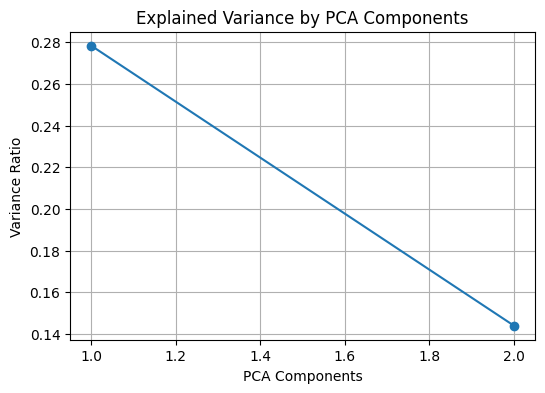

In [30]:
# Plot explained variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Variance Ratio')
plt.grid(True)
plt.show()

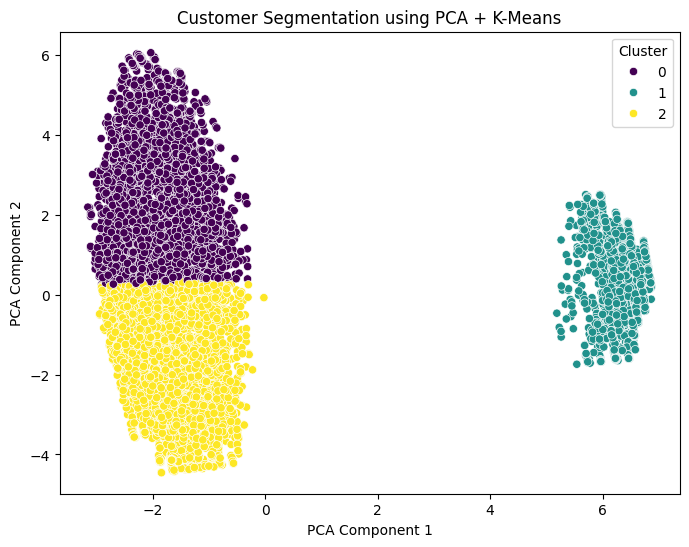

In [32]:
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plot PCA with K-means clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Customer Segmentation using PCA + K-Means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()